In [2]:
# -*- coding: utf-8 -*-

"""
Created January 29, 2023
"""

import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler


DATA_DIR = (
    "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/pixel_patterns"
)
BOX_CSV = "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/pixel_patterns/image_box_agg.csv"
IMAGE_CSV = "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/pixel_patterns/image_box_agg.csv"
DICOM_METADATA_PATH = "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/results_bias/data/dicom_metadata_df.pkl"
VARIABLES_OF_INTEREST = [
    "(0008, 0070) Manufacturer",
    "(0008, 1090) Manufacturer's Model Name",
    "(0012, 0030) Clinical Trial Site ID",
    "(0018, 1000) Device Serial Number",
]
RANDOM_STATE = 33


In [3]:
boxes = pd.read_csv(os.path.join(DATA_DIR, "boxes.csv"))
image_boxes = pd.read_csv(os.path.join(DATA_DIR, "image_box_agg.csv"))


In [4]:
df_boxes = boxes.merge(image_boxes, on="image", how="inner").drop(
    columns=["path_x", "path_y", "Unnamed: 0_x", "Unnamed: 0_y"]
)

df_boxes["join_id"] = df_boxes["image"].astype("int64")

df_boxes


,image,percent_total_area,horizontal_side,vertical_side,area_sum,area_sum_without_edges,n_boxes,join_id
0,3769001,1.008949,edge,edge,1.008949,0.000000,1,3769001
1,615703,1.008949,edge,edge,1.008949,0.000000,1,615703
2,3791802,1.008949,edge,edge,1.008949,0.000000,1,3791802
3,1638304,1.008949,edge,edge,1.008949,0.000000,1,1638304
4,2612401,1.008949,edge,edge,1.008949,0.000000,2,2612401
...,...,...,...,...,...,...,...,...
44263,3515401,0.001016,indeterminate,indeterminate,0.001016,0.001016,1,3515401
44264,3815302,0.001016,indeterminate,bottom,0.001016,0.001016,1,3815302
44265,3972401,0.001016,left,indeterminate,0.001016,0.001016,1,3972401
44266,3223704,0.001016,right,top,0.001016,0.001016,1,3223704


In [5]:
with open(DICOM_METADATA_PATH, "rb") as f:
    dicom_metadata = pickle.load(f)


def merge_metadata(target_variable):
    df_dicom_metadata = dicom_metadata.copy()
    df_dicom_metadata["join_id"] = dicom_metadata.index.values.astype("int64")
    df_dicom_metadata = df_dicom_metadata[["join_id", target_variable]]

    df = df_boxes.merge(df_dicom_metadata, on="join_id", how="inner").drop(
        columns=["join_id", "image"]
    )

    df = df.dropna(subset=[target_variable])

    return df


def is_categorical(c, test_type=np.float64):
    try:
        return not (np.issubdtype(c, np.float64) or np.issubdtype(c, np.int64))
    except:
        return True


def preprocess_data(target_variable):
    df = merge_metadata(target_variable)
    y = df[target_variable]
    xt = df.drop([target_variable], axis=1)

    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    categorical_features = xt.columns[xt.dtypes.apply(lambda c: is_categorical(c))]
    numeric_features = xt.columns[xt.dtypes.apply(lambda c: not is_categorical(c))]
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        verbose_feature_names_out=True,
    )

    preprocessor.fit(xt)

    feature_names = []
    for name, transformer, features in preprocessor.get_params()["transformers"]:
        try:
            feature_names += (
                preprocessor.named_transformers_[name].get_feature_names_out().tolist()
            )
        except AttributeError:
            feature_names += features.tolist()

    return preprocessor.transform(xt), y, feature_names


def get_model_metrics(target_variable, model=SGDClassifier, **params):
    model_xt, y, _ = preprocess_data(target_variable)

    X_train, X_test, y_train, y_test = train_test_split(
        model_xt, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )

    clf = model(**params).fit(X_train, y_train)

    y_test_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    return {
        "accuracy": metrics.accuracy_score(y_test, y_test_pred),
        "report": metrics.classification_report(y_test, y_test_pred, zero_division=0),
        "model": clf,
        "y_train": y_train,
        "y_test": y_test,
        "y_test_pred": y_test_pred,
        "y_score": y_score,
    }


def get_model_params(target_variable):
    model_xt, y, _ = preprocess_data(target_variable)

    X_train, X_test, y_train, y_test = train_test_split(
        model_xt, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )

    grid = GridSearchCV(
        SGDClassifier(max_iter=1000),
        param_grid={
            "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
            "alpha": [0.0001, 0.001, 0.01, 0.1],
            "penalty": ["l2", "l1", "elasticnet", "none"],
        },
        verbose=1,
        cv=3,
    ).fit(X_train, y_train)

    return grid.best_params_


def plot_histogram(target_variable, ax):
    ax.hist(merge_metadata(target_variable)[target_variable])
    ax.set_title(target_variable)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    return ax


def plot_roc(model_metrics):
    label_binarizer = LabelBinarizer().fit(model_metrics["y_train"])
    y_onehot_test = label_binarizer.transform(model_metrics["y_test"])
    y_onehot_test.shape
    y_score = model_metrics["y_score"]

    nrows = len(label_binarizer.classes_) // 2

    fig, ax = plt.subplots(
        nrows=nrows, ncols=2, figsize=(nrows * 2, nrows * 2), constrained_layout=True
    )

    for i, class_of_interest in enumerate(label_binarizer.classes_):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        class_ax = ax[i // 2, i % 2]

        display = metrics.RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color="darkorange",
            ax=class_ax,
        )

        class_ax.set_xlabel("False Positive Rate")
        class_ax.set_ylabel("True Positive Rate")
        class_ax.set_title(f"ROC {class_of_interest}")

    return ax


## Variable Histograms

Class imbalances can be seen in device serial number and manufacturer models when viewing histograms of each variable.

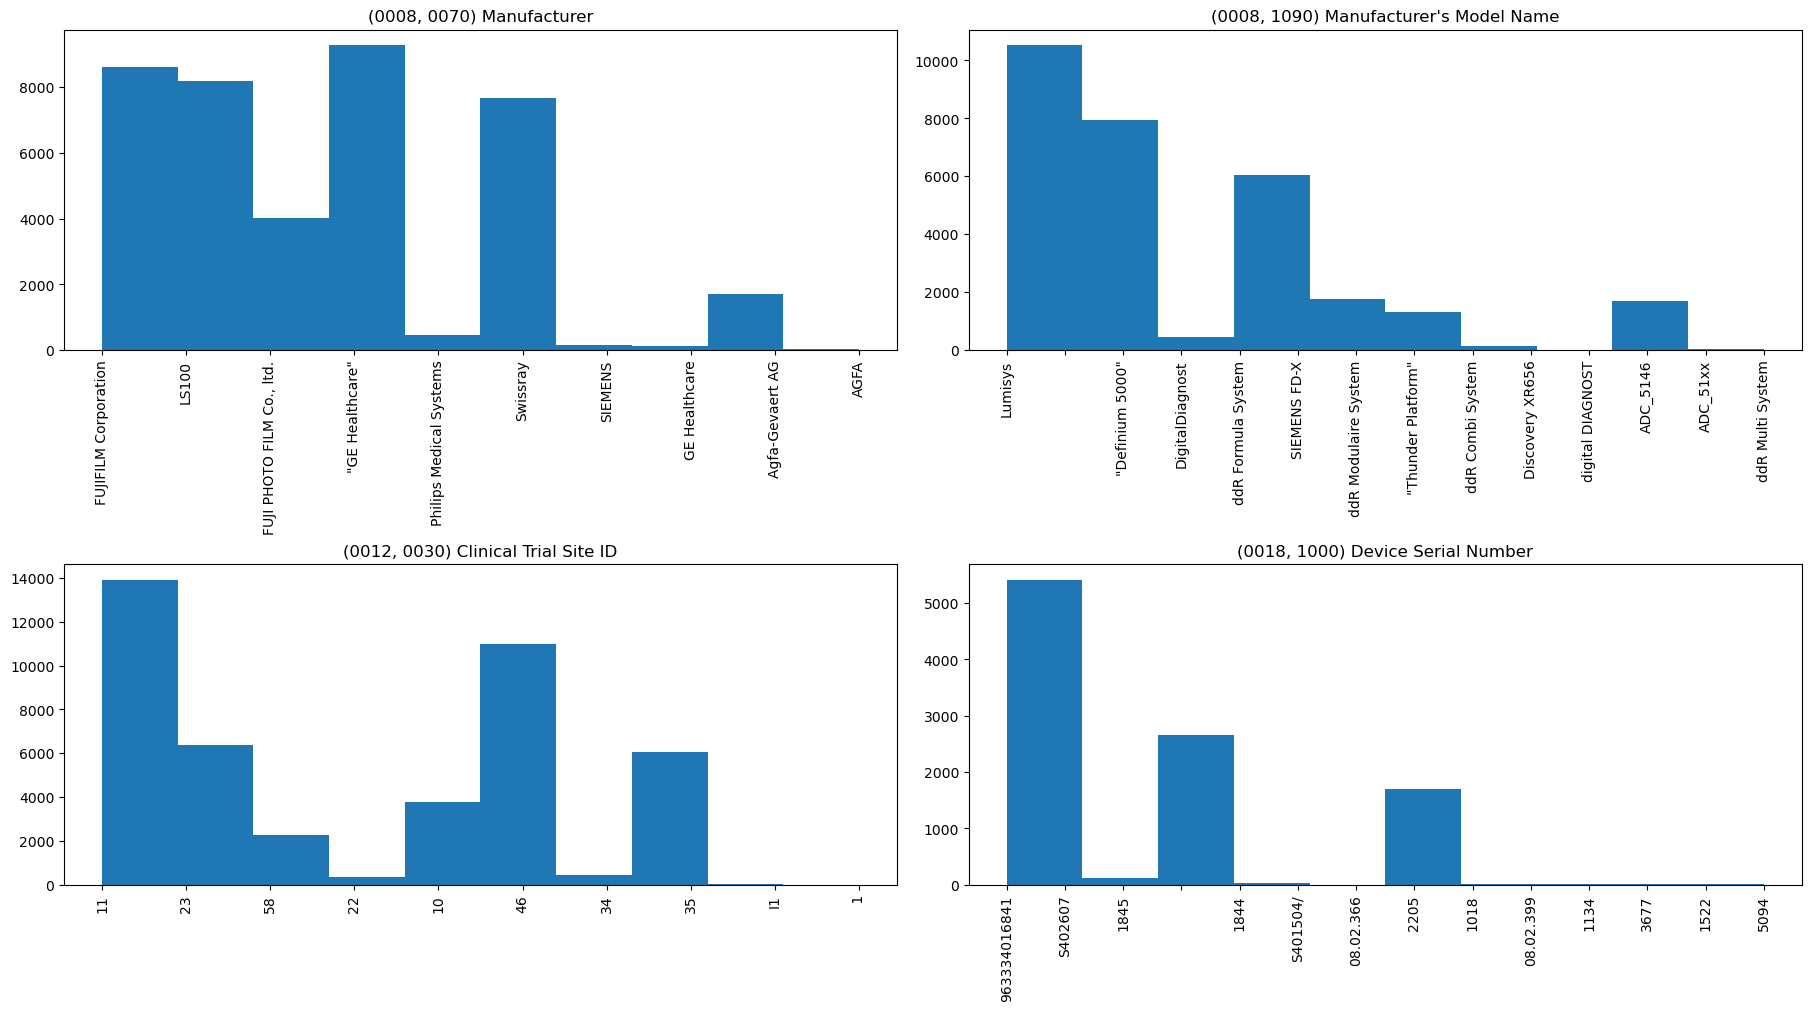

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10), constrained_layout=True)

plot_histogram(VARIABLES_OF_INTEREST[0], ax[0, 0])
plot_histogram(VARIABLES_OF_INTEREST[1], ax[0, 1])
plot_histogram(VARIABLES_OF_INTEREST[2], ax[1, 0])
plot_histogram(VARIABLES_OF_INTEREST[3], ax[1, 1])

plt.show()


Fitting 3 folds for each of 80 candidates, totalling 240 fits

    Variable: (0008, 0070) Manufacturer with a model accuracy of 0.48229208117787503

                               precision    recall  f1-score   support

          "GE Healthcare"       0.47      0.61      0.53      2320
                     AGFA       0.00      0.00      0.00        10
          Agfa-Gevaert AG       0.67      0.65      0.66       428
FUJI PHOTO FILM Co., ltd.       0.46      0.11      0.18      1002
     FUJIFILM Corporation       0.54      0.64      0.59      2148
            GE Healthcare       0.00      0.00      0.00        30
                    LS100       0.50      0.46      0.48      2048
  Philips Medical Systems       0.00      0.00      0.00       114
                  SIEMENS       0.00      0.00      0.00        35
                 Swissray       0.38      0.38      0.38      1917

                 accuracy                           0.48     10052
                macro avg       0.30     

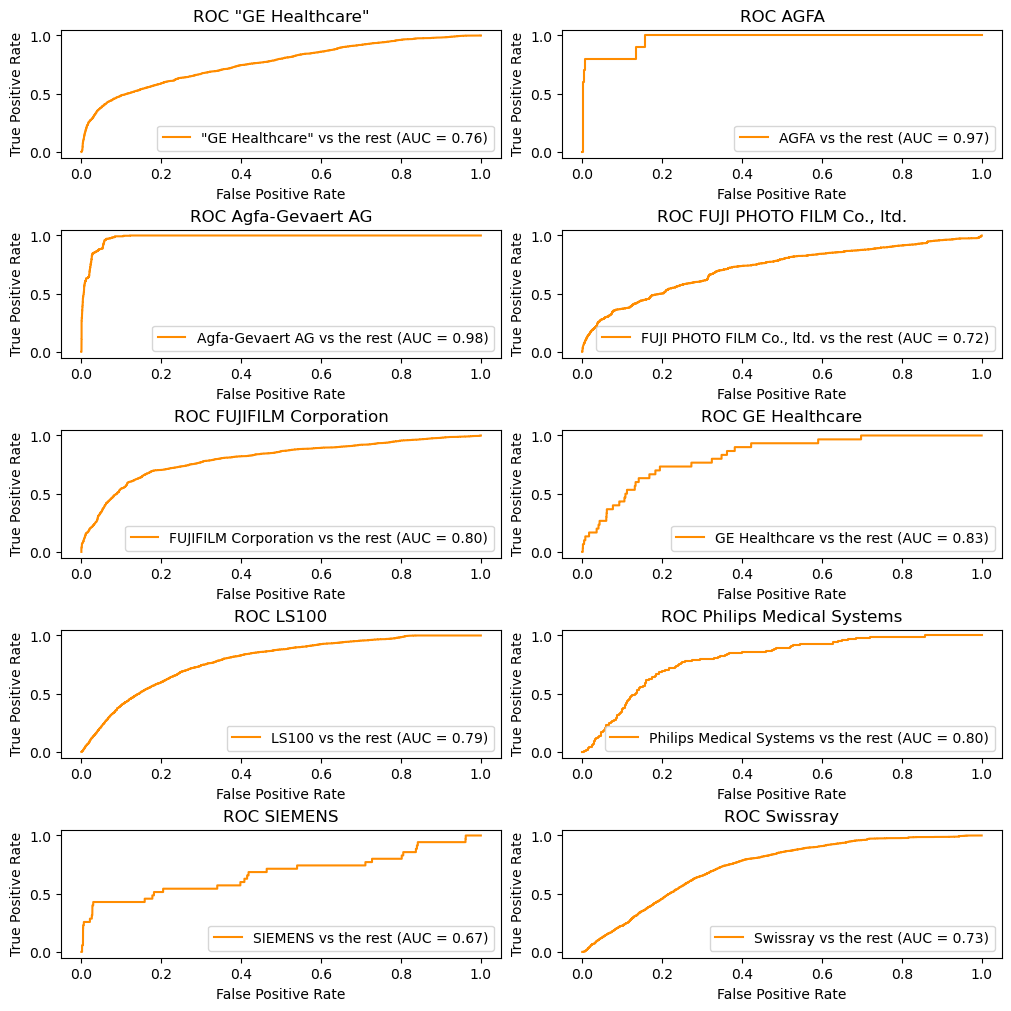

Fitting 3 folds for each of 80 candidates, totalling 240 fits

    Variable: (0008, 1090) Manufacturer's Model Name with a model accuracy of 0.4700854700854701

                          precision    recall  f1-score   support

                           0.56      0.10      0.17       728
     "Definium 5000"       0.45      0.75      0.56      1989
  "Thunder Platform"       0.00      0.00      0.00       331
            ADC_5146       0.81      0.83      0.82       428
            ADC_51xx       0.00      0.00      0.00        10
     DigitalDiagnost       0.00      0.00      0.00       111
     Discovery XR656       0.00      0.00      0.00        30
             Lumisys       0.49      0.56      0.52      1906
        SIEMENS FD-X       0.00      0.00      0.00        36
    ddR Combi System       0.00      0.00      0.00         1
  ddR Formula System       0.37      0.36      0.37      1478
ddR Modulaire System       0.00      0.00      0.00       437
    ddR Multi System       0

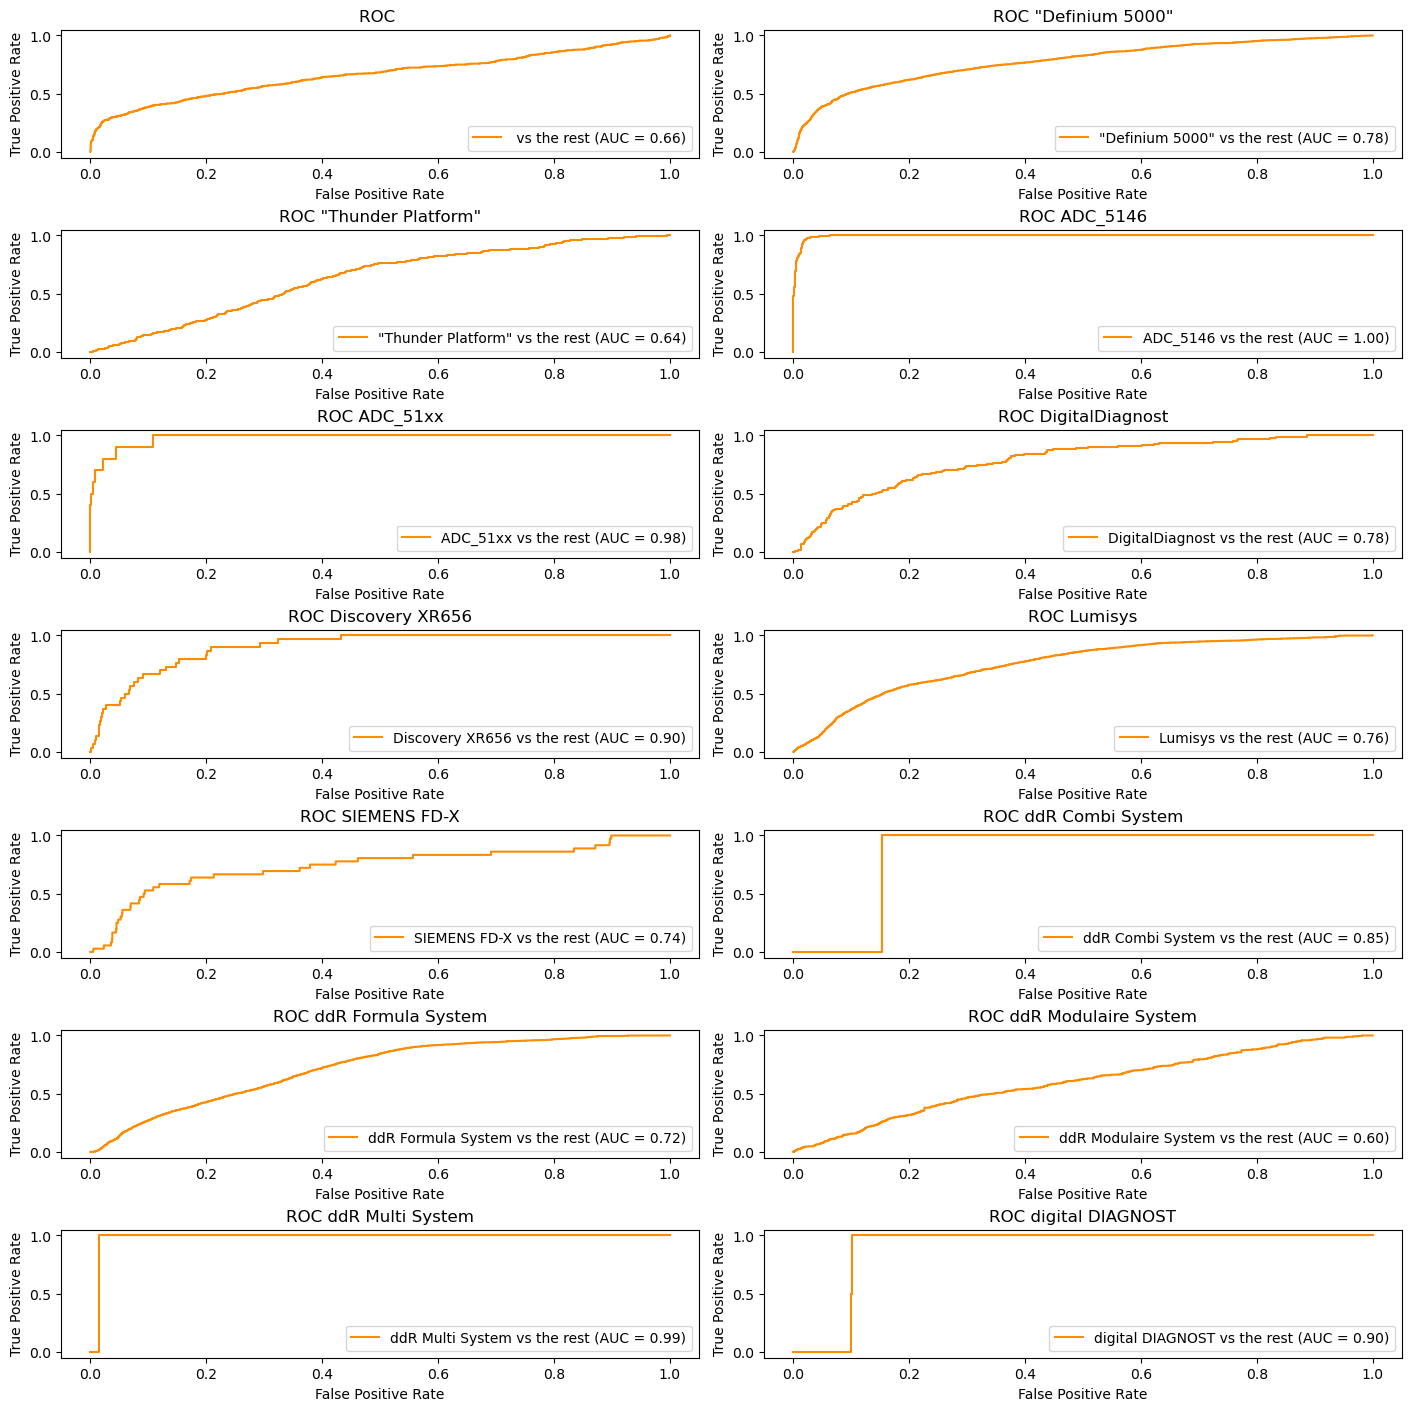

Fitting 3 folds for each of 80 candidates, totalling 240 fits

    Variable: (0012, 0030) Clinical Trial Site ID with a model accuracy of 0.38236889692585896

                  precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00       942
          11       0.35      0.97      0.51      3483
          22       0.00      0.00      0.00        85
          23       0.71      0.05      0.09      1599
          34       0.00      0.00      0.00       111
          35       0.05      0.00      0.00      1520
          46       0.65      0.28      0.39      2748
          58       0.00      0.00      0.00       568
          I1       0.00      0.00      0.00         3

    accuracy                           0.38     11060
   macro avg       0.18      0.13      0.10     11060
weighted avg       0.38      0.38      0.27     11060


    


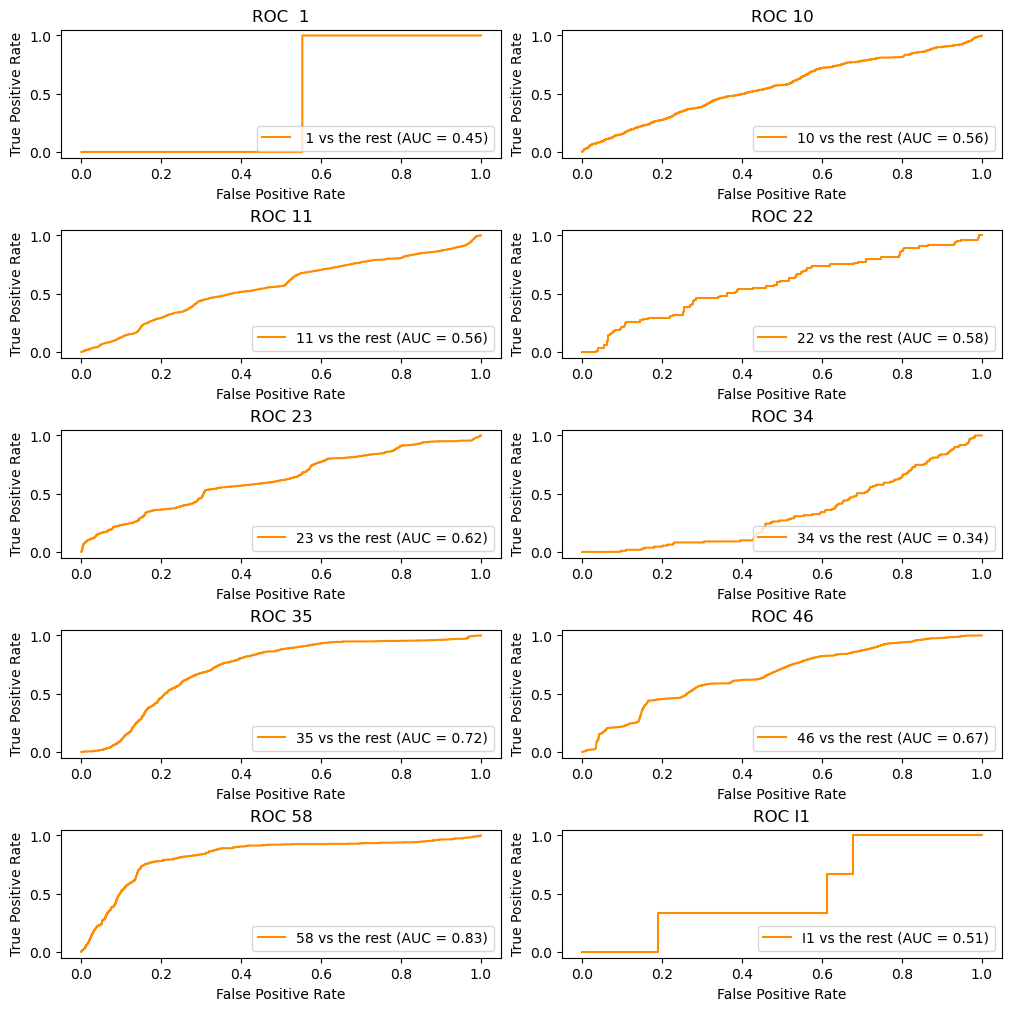

Fitting 3 folds for each of 80 candidates, totalling 240 fits

    Variable: (0018, 1000) Device Serial Number with a model accuracy of 0.6693354683746997

                  precision    recall  f1-score   support

                   0.50      0.10      0.17       663
   08.02.366       0.00      0.00      0.00         1
   08.02.399       0.00      0.00      0.00         1
        1018       0.00      0.00      0.00         3
        1134       0.00      0.00      0.00         6
        1522       0.00      0.00      0.00         1
        1844       0.00      0.00      0.00         3
        1845       0.00      0.00      0.00        32
        2205       0.90      0.96      0.93       425
        3677       0.00      0.00      0.00         3
        5094       0.00      0.00      0.00         1
963334016841       0.00      0.00      0.00       111
    S401504/       0.00      0.00      0.00         5
     S402607       0.63      0.96      0.76      1243

    accuracy                

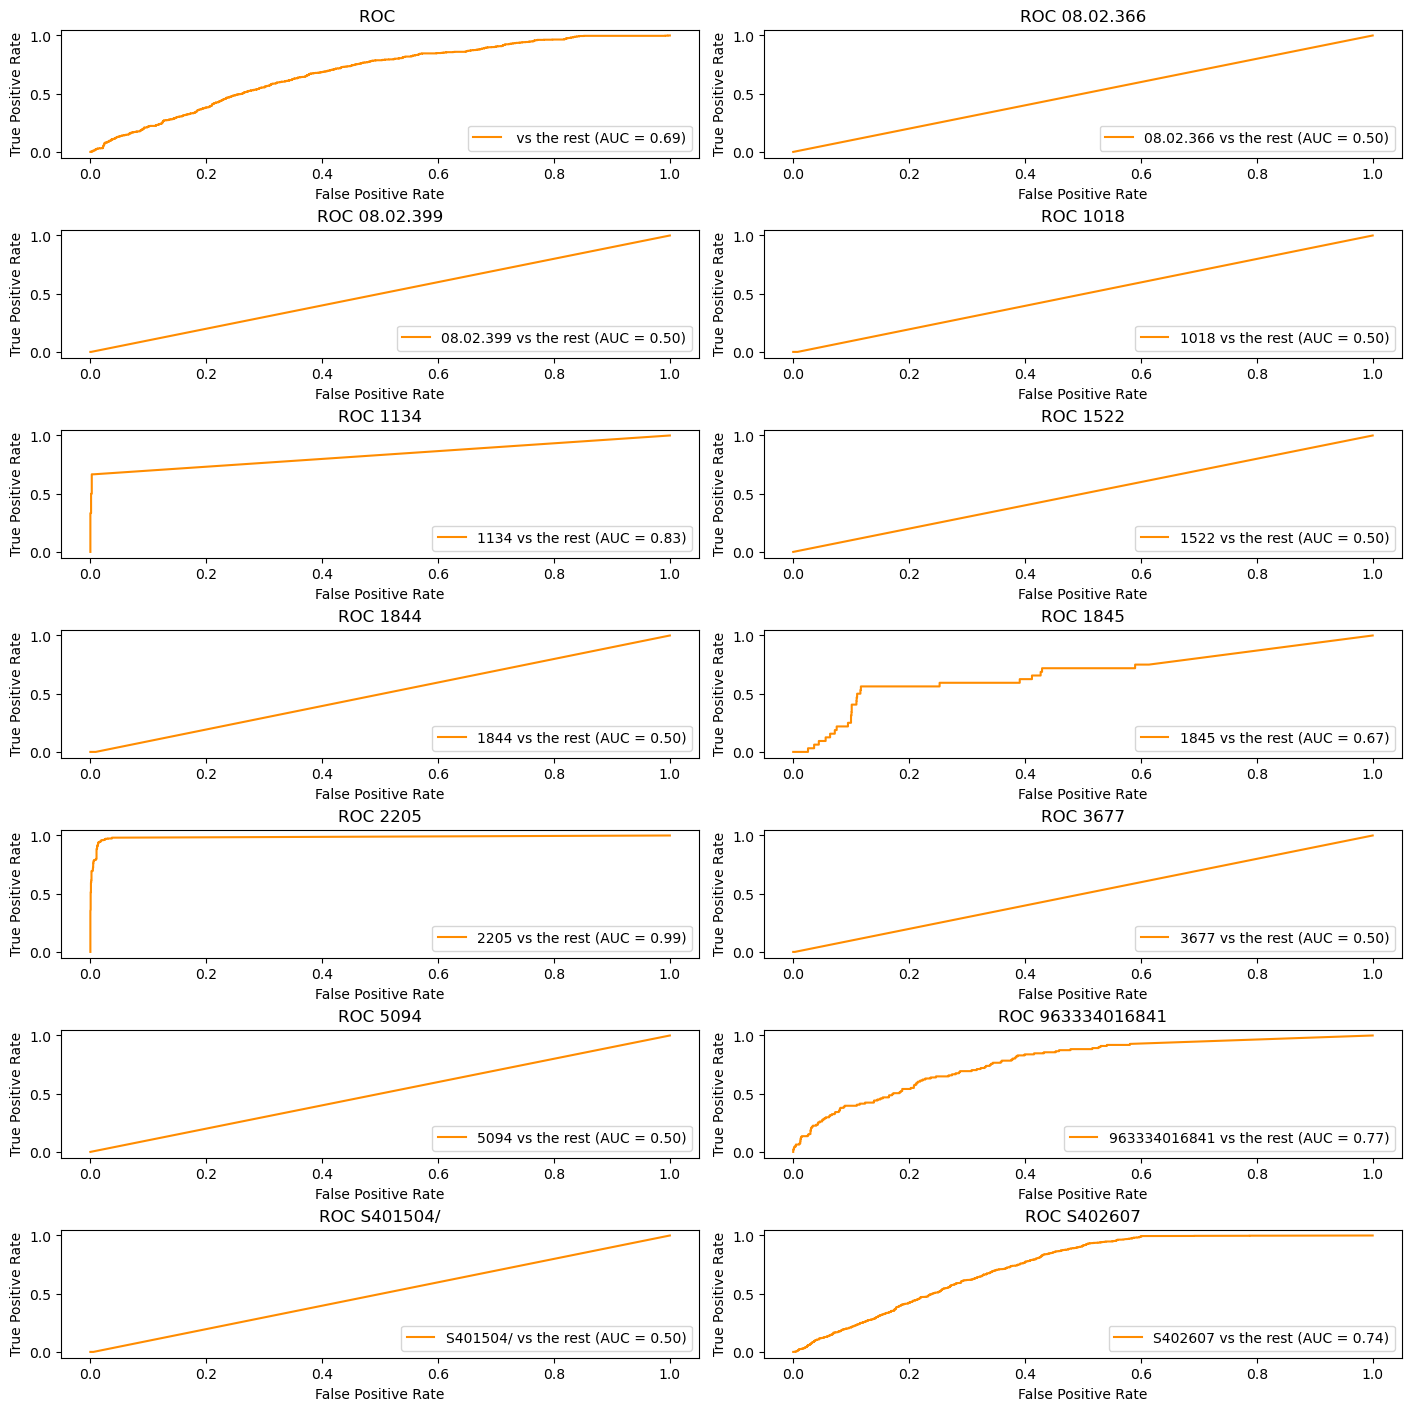

In [7]:
warnings.filterwarnings("ignore")

for var in VARIABLES_OF_INTEREST:
    params = get_model_params(var)
    model_metrics = get_model_metrics(var, **params)

    report = f"""
    Variable: {var} with a model accuracy of {model_metrics['accuracy']}

    {model_metrics['report']}

    {'=' * 100}
    """

    print(report)
    plot_roc(model_metrics)

    plt.show()


# Serial Number Prediction

Similar accuracy numbers are obtained with logistic regression.

In [10]:
get_model_metrics(VARIABLES_OF_INTEREST[3], LogisticRegression)["accuracy"]


0.6709367493995196

## Serial Model Counts

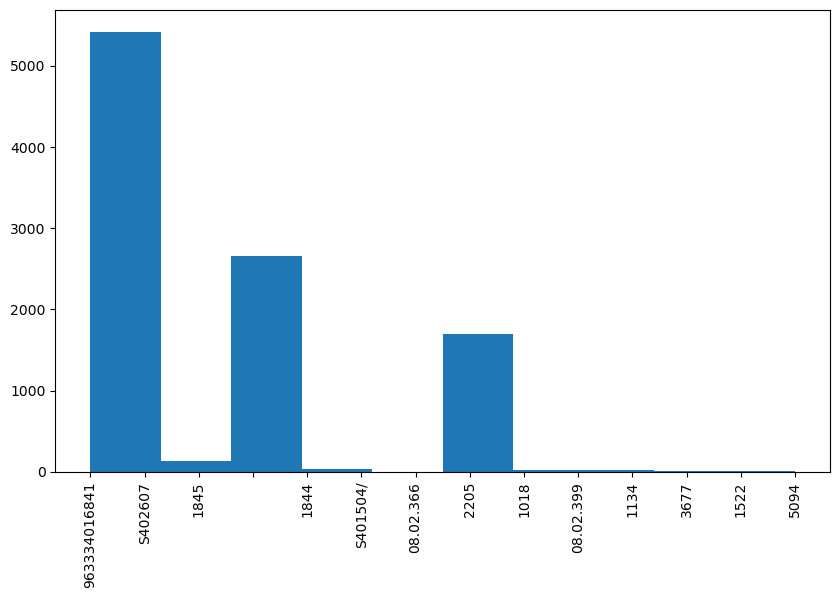

In [11]:
serial_number = VARIABLES_OF_INTEREST[3]

plt.figure(figsize=(10, 6))
plt.hist(merge_metadata(serial_number)[serial_number])
plt.xticks(rotation=90)
plt.show()


In [12]:
model_xt, y, features = preprocess_data(serial_number)

X_train, X_test, y_train, y_test = train_test_split(
    model_xt, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

model = SGDClassifier(loss="hinge", penalty="l1").fit(X_train, y_train)

results = permutation_importance(
    model, X_train, y_train, random_state=RANDOM_STATE, n_jobs=-1
)


Feature: percent_total_area, Score: 0.05751267680811314
Feature: area_sum, Score: 0.2021884174005871
Feature: area_sum_without_edges, Score: 0.0682946357085668
Feature: n_boxes, Score: 0.0016546570589804465
Feature: horizontal_side_edge, Score: 0.00018681611956226086
Feature: horizontal_side_indeterminate, Score: 0.012676808113157145
Feature: horizontal_side_left, Score: 0.033279957299172616
Feature: horizontal_side_right, Score: 0.03661595943421399
Feature: vertical_side_bottom, Score: 0.013370696557245765
Feature: vertical_side_edge, Score: 0.05289564985321584
Feature: vertical_side_indeterminate, Score: 0.013157192420603115
Feature: vertical_side_top, Score: 0.004723779023218499


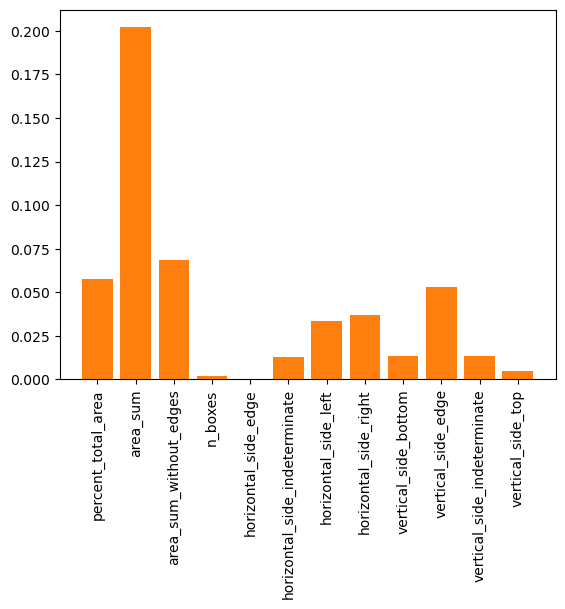

In [13]:
for i, v in enumerate(results.importances_mean):
    print(f"Feature: {features[i]}, Score: {v}")
    plt.bar(features, results.importances_mean)

plt.xticks(rotation=90)
plt.show()


## Serial Numbers

There is a bit of a class imbalance issue with the largest number of serial numbers being `9633..`.  The most important feature in classifcation according to permutation importance is the area sum followed by the area sum without a corresponding edge. 

